In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

In [3]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness, get_distinctness_from_nearest_5, aggregate_embeddings_visual_and_language
from utils.utils_funcs import load_data_to_dict

In [4]:
save_fig=True

In [5]:
# sns.set_style('darkgrid')  # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)  # fontsize of the axes title
plt.rc('axes', labelsize=18)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.rc('legend', fontsize=18)  # legend fontsize
plt.rc('font', size=18)  # controls default text sizes
# plt.figure(figsize=(10, 6), tight_layout=True)

In [6]:
def combine_nouns_and_verbs(struct1,struct2):
    words_full=list()
    embeds_full=dict()
    for w in struct1["embeds"]:
        ww=w+"_n"
        temp=dict()
        temp["visual"]=struct1["embeds"][w]["visual"]
        temp["language"]=struct1["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    for w in struct2["embeds"]:
        ww=w+"_v"
        temp=dict()
        temp["visual"]=struct2["embeds"][w]["visual"]
        temp["language"]=struct2["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    data_full=dict(
        embeds=embeds_full,
        words=words_full
    )
    return data_full

In [7]:
def get_concept_level_alignment_strength(struct,concepts,targets):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    rt=list()
    for target in targets:
        idx=concepts.index(target)
        aln=spearmanr(sim_z_0[idx],sim_z_1[idx])[0]
        if aln>0:
            rt.append(aln)
        else:
            rt.append(0)
    return rt

In [8]:
def combine_all_data(data,aoa_dict,v_var_dict,l_var_dict,v_dist_dict,l_dist_dict,freq_dict):
    aoas=list()
    v_vars=list()
    l_vars=list()
    v_dists=list()
    l_dists=list()
    freqs=list()
    
    intersect_concepts=list()
    for concept in aoa_dict:
        if concept not in freq_dict:
            print(concept)
        elif concept in data['words']:
            aoas.append(aoa_dict[concept])
            v_vars.append(v_var_dict[concept])
            l_vars.append(l_var_dict[concept])
            v_dists.append(v_dist_dict[concept])
            l_dists.append(l_dist_dict[concept])
            freqs.append(freq_dict[concept])
            intersect_concepts.append(concept)
    alignments=get_concept_level_alignment_strength(data,data['words'],intersect_concepts)
    return aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs

-----

In [9]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_least20_ll_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_least20_ll_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

----

In [10]:
noun_aoa_dict=load_data_to_dict("../data/processed/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"],header=True)
verb_aoa_dict=load_data_to_dict("../data/processed/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"],header=True)

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

----

In [13]:
noun_freq_dict=load_data_to_dict("../data/processed/childes_noun_freq.txt",header=True)
verb_freq_dict=load_data_to_dict("../data/processed/childes_verb_freq.txt",header=True)

----

In [14]:
noun_visual_variability,noun_language_variability=get_variance(vg_noun_data)
verb_visual_variability,verb_language_variability=get_variance(vg_verb_data)

In [15]:
noun_visual_discriminability,noun_language_discriminability=get_distinctness(vg_noun_data)
verb_visual_discriminability,verb_language_discriminability=get_distinctness(vg_verb_data)

In [16]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_noun_data,noun_aoa_dict,
                                                              noun_visual_variability,noun_language_variability,
                                                              noun_visual_discriminability,noun_language_discriminability,
                                                                    noun_freq_dict)

In [17]:
columns=['AoA','Alignment','Visual Variability','Linguistic Variability','Visual Discriminability','Linguistic Discriminability','Word Frequency']

In [18]:
df1=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=columns)
df1['Word Type']=0

In [19]:
# df1

In [20]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_verb_data,verb_aoa_dict,
                                                              verb_visual_variability,verb_language_variability,
                                                              verb_visual_discriminability,verb_language_discriminability,
                                                                    verb_freq_dict)

In [21]:
df2=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=columns)
df2['Word Type']=1

In [22]:
# df2

In [23]:
df=pd.concat([df1,df2])

In [24]:
df.head()

,AoA,Alignment,Visual Variability,Linguistic Variability,Visual Discriminability,Linguistic Discriminability,Word Frequency,Word Type
0,17.0,0.068784,0.865282,8.678675,1.134053,13.393748,3410.0,0
1,17.0,0.409853,0.786357,9.337286,1.084944,14.037375,13592.0,0
2,17.0,0.354752,0.577686,10.010679,0.991527,14.310647,1820.0,0
3,17.0,0.290982,0.621760,10.225678,1.007568,14.243225,5888.0,0
4,18.0,0.139111,0.650536,7.966711,1.153128,12.994579,7092.0,0


### Xgboost

In [25]:
x=df.iloc[:,1:]

In [26]:
y=df.iloc[:,:1]

In [27]:
xg_reg = xgb.XGBRegressor(max_depth=20,subsample=0.5,n_estimators=10000,learning_rate=0.02)

In [28]:
model=xg_reg.fit(x,y)

In [29]:
shap_values = shap.TreeExplainer(model).shap_values(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


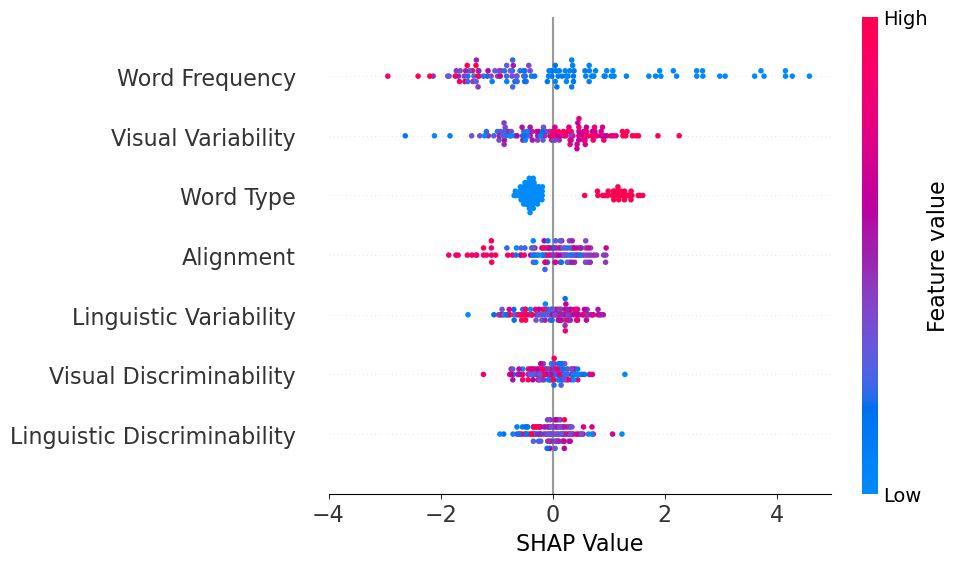

In [30]:
f = plt.figure()
shap.summary_plot(shap_values, x, show=False)

fig, ax = plt.gcf(), plt.gca()
# main figure settings
fig.set_size_inches(10, 6)
ax.tick_params(labelsize=16)
ax.set_xlabel("SHAP Value",fontsize=16)
plt.xticks([-4,-2,0,2,4])

# color bar settings
cb_ax = fig.axes[1]

cb_ax.tick_params(labelsize=14)
cb_ax.set_ylabel("Feature value", fontsize=16)

cb_ax.set_aspect('auto')
plt.tight_layout()
cb_ax.set_box_aspect(30) 

if save_fig:
    f.savefig("../figs/shap_summary_vg.png", bbox_inches='tight', dpi=600)

In [31]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'#ff0051','#008bfb')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    

    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,6),legend=False, fontsize=16)
    figure_size = plt.gcf().get_size_inches()
    print(figure_size)
    for i, v in enumerate(k2['SHAP_abs']):
        ax.text(v+0.02, i-0.1, "{:.2f}".format(v), color='black', fontsize=16)
    ax.set_xlabel("Mean Absolute SHAP Value (Red = Positive Impact)",fontsize=16)
    # xticks=range(0,2,0.2)
    # ax.xticks(xticks,xticks)
    plt.xlim(0, 1.6)
    ax.set_xticks([0,0.5,1.0,1.5])
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if save_fig:
        plt.savefig("../figs/shap_summary_value_vg.png", bbox_inches='tight', dpi=1000)
    

[10.  6.]


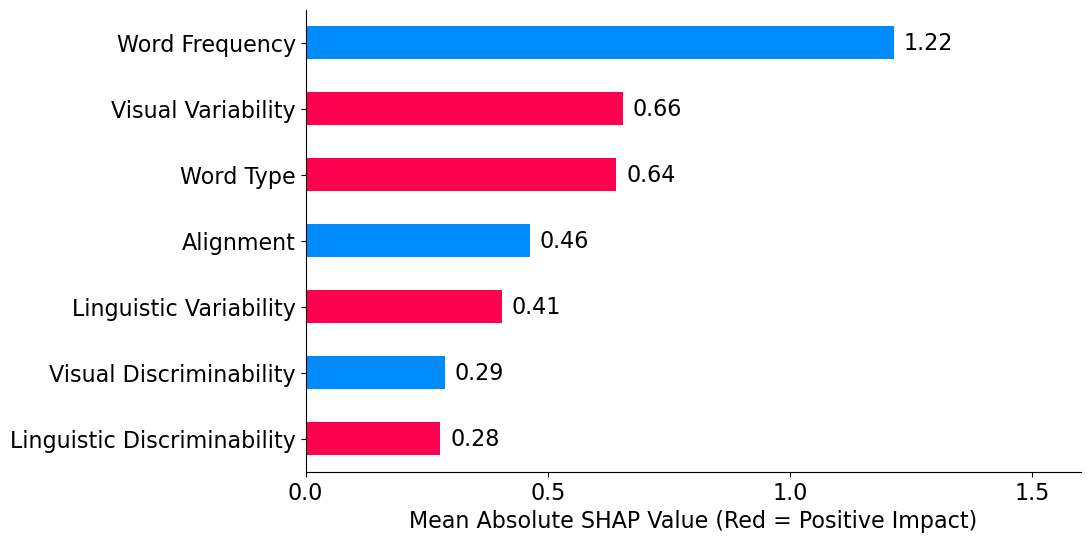

In [32]:
ABS_SHAP(shap_values,x)